<a href="https://colab.research.google.com/github/datasocode/Analyse-de-Clustering-et-ACP/blob/main/Donne%CC%81es_et_De%CC%81cisions_Analyse_des_Marche%CC%81s_Potentiels_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard Scaler import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from sklearn import decomposition
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import folium
import json

# Standard Scaler

In [ ]:
df2 = pd.read_csv('df2.csv')

In [ ]:
df2.head(2)

,Zone,Disponibilité intérieure,Dispo_volailles(%),Exportations - Quantité,Importations - Quantité,Nourriture,Production,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur,+Population(%),obesite(%),Indice_logistique,Inflation%
0,Grenade,8.0,9.20,0.0,7.0,5.0,1.0,87.50,12.50,25.00,22.79,1.01,3.19,11.52,2.500000,2.92
1,Trinité-et-Tobago,76.0,8.51,0.0,23.0,75.0,61.0,30.26,80.26,6.17,-8.58,0.28,2.92,14.11,2.372439,6.57


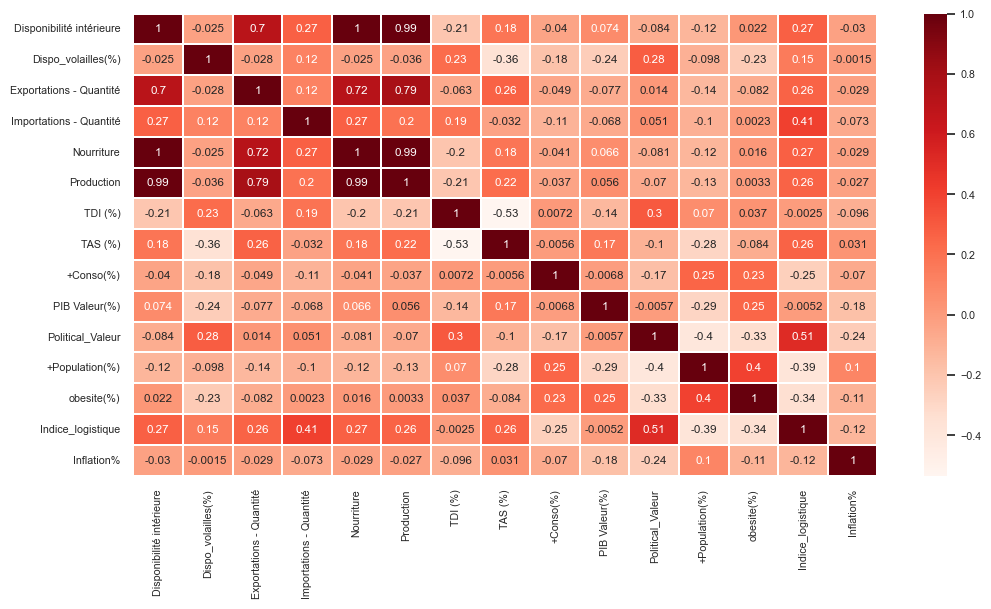

In [ ]:
sns.set(font_scale=0.7)
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corrmat, ax=ax, cmap="Reds", linewidths=0.1, annot=True)
plt.savefig("graph.png", bbox_inches='tight')
plt.show()

* Colonnes "production" et "nourriture" supprimées
en raison de leur forte corrélation pour éviter la multicollinéarité

In [ ]:
# Calculer la matrice de corrélation
correlation_matrix = df2.corr()

# Identifier les paires de variables fortement corrélées
strongly_correlated = []
threshold = 0.8  # Définir un seuil de corrélation

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            strongly_correlated.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

# Supprimer l'une des variables dans chaque paire de variables fortement corrélées
df2 = df2.drop([var2 for var1, var2 in strongly_correlated], axis=1)
df2.head(2)

,Zone,Disponibilité intérieure,Dispo_volailles(%),Exportations - Quantité,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur,+Population(%),obesite(%),Indice_logistique,Inflation%
0,Grenade,8.0,9.20,0.0,7.0,87.50,12.50,25.00,22.79,1.01,3.19,11.52,2.500000,2.92
1,Trinité-et-Tobago,76.0,8.51,0.0,23.0,30.26,80.26,6.17,-8.58,0.28,2.92,14.11,2.372439,6.57


* Après avoir testé plusieurs variables, j'ai finalement sélectionné uniquement 7 variables pour mon analyse

In [ ]:
df2 = df2.drop(['Exportations - Quantité','obesite(%)','Inflation%','Dispo_volailles(%)',
                'Indice_logistique','+Population(%)'], axis=1)
df2.head(2)

,Zone,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
0,Grenade,8.0,7.0,87.50,12.50,25.00,22.79,1.01
1,Trinité-et-Tobago,76.0,23.0,30.26,80.26,6.17,-8.58,0.28


In [ ]:
df2.keys()

Index(['Zone', 'Disponibilité intérieure', 'Importations - Quantité',
       'TDI (%)', 'TAS (%)', '+Conso(%)', 'PIB Valeur(%)', 'Political_Valeur'],
      dtype='object')

In [ ]:
columns = ['Disponibilité intérieure', 'Importations - Quantité',
       'TDI (%)', 'TAS (%)', '+Conso(%)', 'PIB Valeur(%)', 'Political_Valeur']
columns

['Disponibilité intérieure',
 'Importations - Quantité',
 'TDI (%)',
 'TAS (%)',
 '+Conso(%)',
 'PIB Valeur(%)',
 'Political_Valeur']

In [ ]:
labels  = np.array(df2['Zone'])
labels

array(['Grenade', 'Trinité-et-Tobago', 'Antigua-et-Barbuda',
       'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Bahamas', 'Israël',
       'Koweït', 'Arabie saoudite', 'Chine - RAS de Hong-Kong', 'Samoa',
       'Chine - RAS de Macao', 'Barbade',
       'Saint-Vincent-et-les Grenadines', 'Jordanie', 'Jamaïque',
       'Suriname', 'Maldives', 'Émirats arabes unis', 'Gabon', 'Pérou',
       'Iraq', 'Afrique du Sud', 'Panama',
       'Venezuela (République bolivarienne du)', 'Nouvelle-Zélande',
       'Chili', 'Yémen', 'Oman', 'Dominique', 'Malte', 'Congo',
       'Cabo Verde', 'Chypre', 'Myanmar',
       "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Japon',
       'République dominicaine', "États-Unis d'Amérique",
       "Iran (République islamique d')", 'Mexique', 'Libéria', 'Géorgie',
       'Lesotho', 'Slovénie', 'Maroc', 'Islande', 'Colombie', 'Portugal',
       'Canada', 'Namibie', 'Honduras', 'Fédération de Russie', 'Espagne',
       'Bulgarie', 'Bolivie (État plurinational 

In [ ]:
df2 = df2.drop(['Zone'], axis=1)
df2.head(2)

,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
0,8.0,7.0,87.50,12.50,25.00,22.79,1.01
1,76.0,23.0,30.26,80.26,6.17,-8.58,0.28


In [ ]:
columns = ['Disponibilité intérieure', 'Importations - Quantité',
       'TDI (%)', 'TAS (%)', '+Conso(%)', 'PIB Valeur(%)', 'Political_Valeur']

* "Standard Scaler" est une étape importante du prétraitement des données qui permet de mettre les variables à la même échelle, garantissant ainsi une analyse équitable et évitant les distorsions causées par des échelles différentes

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
df2 = pd.DataFrame(stdsc.fit_transform(df2))
df2.index = labels
df2.columns = columns

In [ ]:
df2.head(2)

,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Grenade,-0.315443,-0.436659,0.801967,-1.429489,-0.107689,1.109516,1.206611
Trinité-et-Tobago,-0.284955,-0.349978,-0.304999,0.049984,-0.428271,-1.646454,0.381219


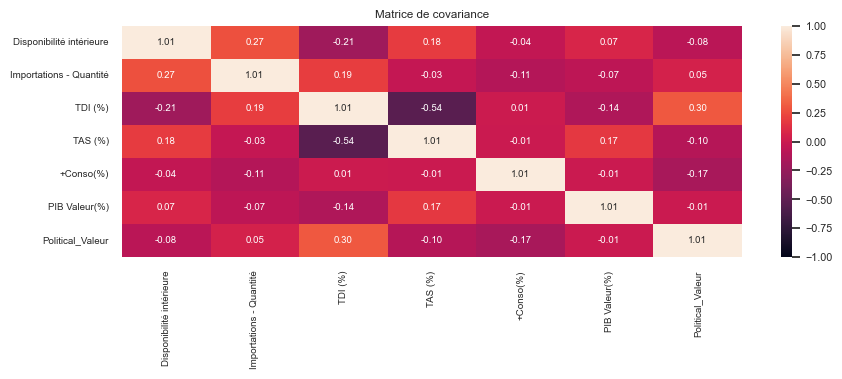

In [ ]:
annot_fontsize = 7

matrix = df2.values

matrix_cov = np.cov(matrix.T, bias=False)

fig, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(matrix_cov, annot=True, fmt=".2f", annot_kws={"size": annot_fontsize},
            xticklabels=columns, yticklabels=columns, ax=ax, vmin=-1, vmax=1)

ax.set_title("Matrice de covariance")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=annot_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=annot_fontsize)

plt.show()

# Analyse en Composantes Principales (ACP)

* L'Analyse en Composantes Principales (ACP) est une technique statistique utilisée pour réduire la dimensionnalité des données, c'est-à-dire pour simplifier un ensemble de variables complexes en un nombre plus petit de variables, appelées composantes principales

In [ ]:
#on prépare un jeux de donnée sans les noms de pays
donnee_pca = df2#.drop('Zone', axis=1)

#je garde les noms de pays
names =df2.index

#on garde les noms de colones
features = donnee_pca.columns

X = donnee_pca.values

#centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#calcul de l'acp
pca = decomposition.PCA(n_components=7)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)
liste_colone = []
for i in range(pca.n_components_):
    liste_colone.append('pca'+str(i+1))

df_pca = pd.DataFrame(X_projected, columns = liste_colone)
df_pca.index = df2.index

In [ ]:
print("Nombre de composante principale", pca.n_components_)
print("Variance expliqué par composante",pca.explained_variance_ratio_)
print("Variance expliqué",pca.explained_variance_ratio_.sum())

Nombre de composante principale 7
Variance expliqué par composante [0.26190435 0.18926158 0.15689888 0.13246836 0.11124845 0.09280035
 0.05541803]
Variance expliqué 1.0


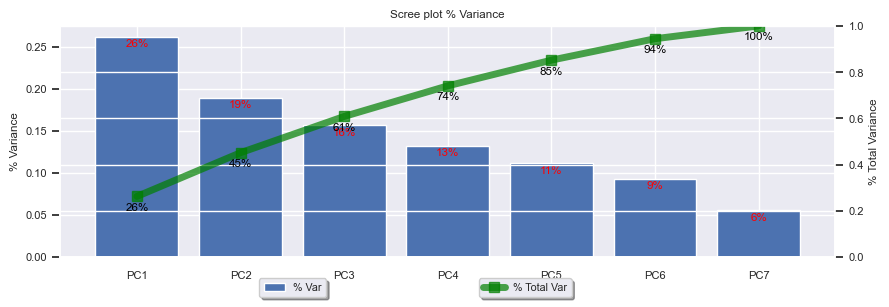

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
df_new = pca.fit_transform(df2)

fig, ax1 = plt.subplots(figsize=(10, 3))

eigen_label = ["PC" + str(i + 1) for i in range(len(pca.explained_variance_ratio_))]
ratio = pca.explained_variance_ratio_
ratio_cumulate = np.cumsum(ratio)

ax1.bar(eigen_label, ratio, label='% Var')
plt.title("Scree plot % Variance")

for x, y in zip(eigen_label, ratio):
    label = "{:.0%}".format(y)
    ax1.annotate(label, (x, y), textcoords="offset points", xytext=(0, -5), ha='center', va='center', color='red')

ax1.set_ylabel('% Variance')

ax2 = ax1.twinx()
ax2.plot(eigen_label, ratio_cumulate, '-s', color='green', markersize=7, linewidth=5, alpha=0.7,
         label='% Total Var')
ax2.set_ylabel('% Total Variance')
ax2.set_ylim(0, 1)

for x, y in zip(eigen_label, ratio_cumulate):
    label = "{:.0%}".format(y)
    ax2.annotate(label, (x, y), textcoords="offset points", xytext=(0, -10), ha='center', color='black')

ax1.legend(loc='upper center', bbox_to_anchor=(0.3, -0.07), fancybox=True, shadow=True, ncol=2)
ax2.legend(loc='upper center', bbox_to_anchor=(0.6, -0.07), fancybox=True, shadow=True, ncol=5)

plt.rc("legend", fontsize=10)

ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='y', labelsize=8);

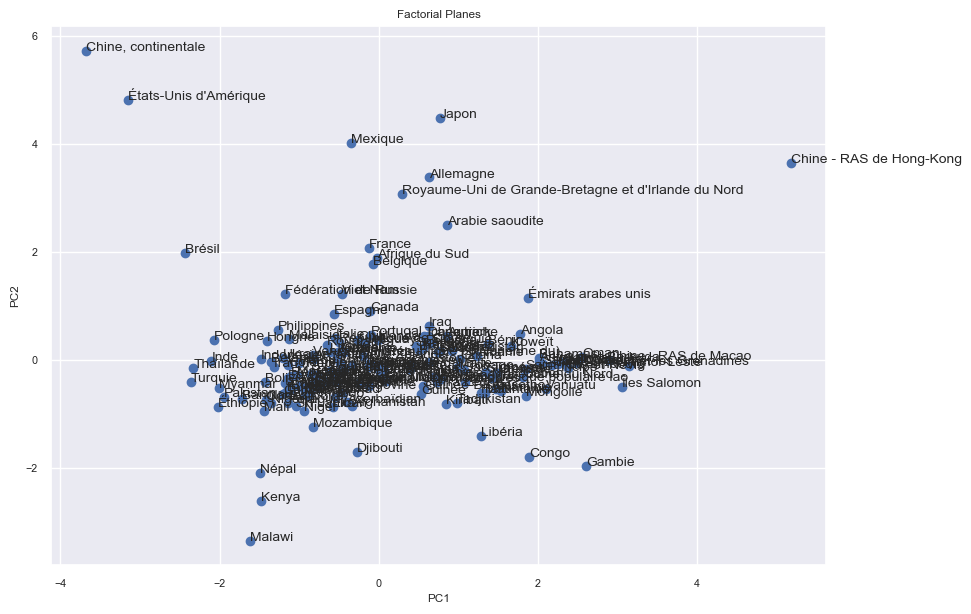

In [ ]:
x = X_projected[:, 0]
y = X_projected[:, 1]

cmap = plt.cm.get_cmap('viridis')

plt.figure(figsize=(10, 7))
plt.scatter(x, y, cmap=cmap, alpha=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Factorial Planes')

for i, txt in enumerate(labels):
    plt.text(x[i], y[i], txt, fontsize=10)

plt.savefig("X_projected.png", bbox_inches='tight')
plt.show()


# Cercle de la Correlation

* Le Cercle de Corrélation est un outil visuel utilisé pour interpréter les résultats d'une Analyse en Composantes Principales (ACP) en mettant en évidence les relations entre les variables d'origine et les composantes principales

In [ ]:
from sklearn.decomposition import PCA
num_components = 7
pca = PCA(n_components=num_components)
pca.fit(X_scaled)

PCA(n_components=7)

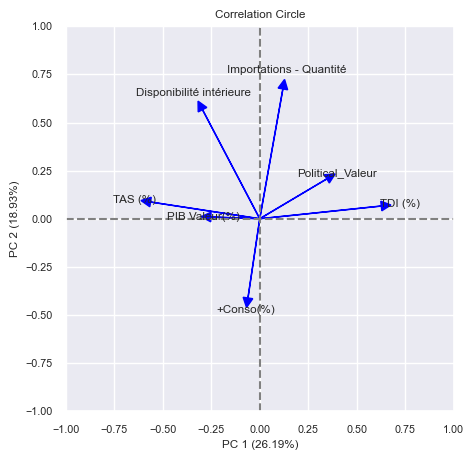

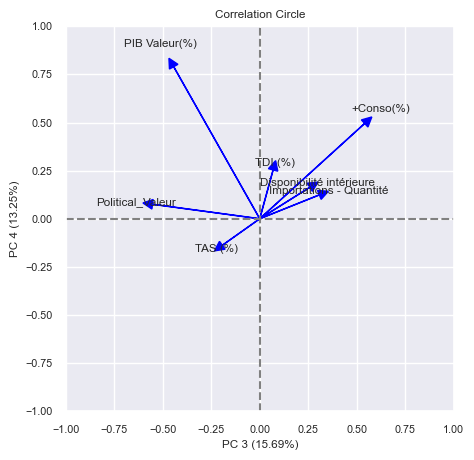

In [ ]:
def generate_correlation_circle(pcs, num_components, pca, dimensions, labels):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axhline(0, color='gray', linestyle='--')
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_xlabel(f'PC {dimensions[0]+1} ({pca.explained_variance_ratio_[dimensions[0]]*100:.2f}%)')
    ax.set_ylabel(f'PC {dimensions[1]+1} ({pca.explained_variance_ratio_[dimensions[1]]*100:.2f}%)')
    ax.set_title('Correlation Circle')

    for i, label in enumerate(labels):
        ax.arrow(0, 0, pcs[dimensions[0], i], pcs[dimensions[1], i],
                 head_width=0.05, head_length=0.05, fc='blue', ec='blue')
        ax.text(pcs[dimensions[0], i]*1.15, pcs[dimensions[1], i]*1.15, label,
                ha='center', va='center')

    plt.savefig("circle.png", bbox_inches='tight')
    plt.show()

variables = df2[['Disponibilité intérieure', 'Importations - Quantité',
       'TDI (%)', 'TAS (%)', '+Conso(%)', 'PIB Valeur(%)', 'Political_Valeur']]
num_components = 7
pcs = pca.components_[:num_components]
labels2 = variables.columns[:num_components]
generate_correlation_circle(pcs, num_components, pca, [0, 1], labels2)
generate_correlation_circle(pcs, num_components, pca, [2, 3], labels2)


In [ ]:
t = pca.components_[:num_components]
df_corr_comp = pd.DataFrame(t, index=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7'], columns=variables.columns)
df_corr_comp

,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
PC1,-0.295417,0.119349,0.627296,-0.563709,-0.060838,-0.252193,0.346287
PC2,0.566546,0.674364,0.066074,0.086967,-0.411525,0.009104,0.207108
PC3,0.258308,0.307516,0.068928,-0.193187,0.541490,-0.444158,-0.553309
PC4,0.163439,0.123913,0.253629,-0.137787,0.494992,0.789903,0.075210
PC5,0.084058,-0.000618,-0.034014,0.414513,0.523512,-0.325290,0.663383
PC6,0.678996,-0.586310,-0.051516,-0.399597,-0.044201,-0.088451,0.151973
PC7,0.173831,-0.278044,0.727492,0.535596,-0.112694,-0.038145,-0.249422


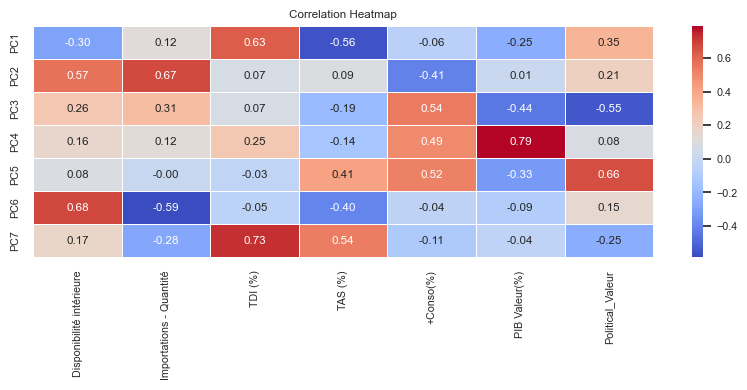

In [ ]:
# Create correlation heatmap
plt.figure(figsize=(10, 3))
sns.heatmap(df_corr_comp, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig("Correlation Heatmap.png", bbox_inches='tight')
plt.show()

# K-MEANS

* Le K-Means est un algorithme de clustering largement utilisé pour regrouper des données en sous-groupes homogènes. L'objectif principal du K-Means est de partitionner les données en K clusters, où chaque cluster représente un groupe de données similaires

In [ ]:
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


/Users/seungeunlee/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'matrix']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


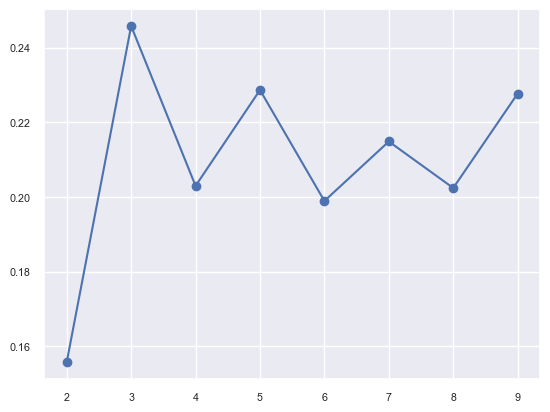

In [ ]:
%pylab inline
from sklearn import cluster, metrics

silhouettes = []
for num_cluster in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_cluster, n_init=1, init='random')
    cls.fit(df2)
    silh = metrics.silhouette_score(df2, cls.labels_)
    silhouettes.append(silh)
plt.plot(range(2, 10), silhouettes, marker='o');

Populating the interactive namespace from numpy and matplotlib


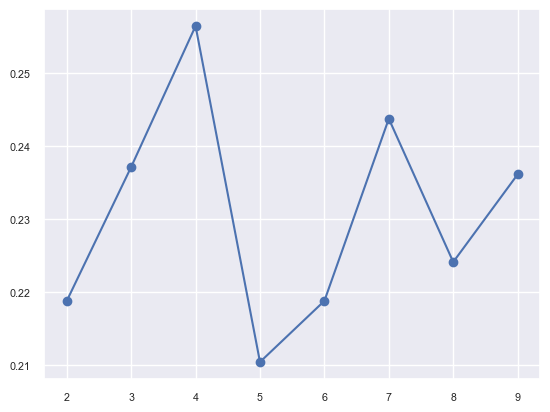

In [ ]:
%pylab inline
from sklearn import cluster, metrics

silhouettes = []
for num_cluster in range(2, 10):
    cls = cluster.KMeans(n_clusters=num_cluster, n_init=1, random_state=2)
    cls.fit(df2)
    silh = metrics.silhouette_score(df2, cls.labels_)
    silhouettes.append(silh)
plt.plot(range(2, 10), silhouettes, marker='o');

# Elbow method

* La méthode du coude (Elbow Method) est une technique couramment utilisée pour déterminer le nombre optimal de clusters dans un algorithme de clustering, tel que le K-Means. Elle est basée sur la variation de l'inertie intra-cluster en fonction du nombre de clusters

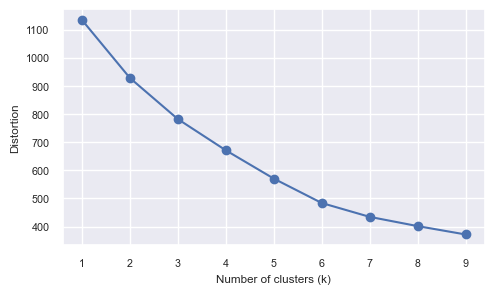

In [ ]:
distortions = []

for i in range(1, 10):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                n_init = 10,
                max_iter = 300,
                random_state = 0)
    km.fit(df2)
    distortions.append(km.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.tight_layout();

In [ ]:
pip install -U yellowbrick

Note: you may need to restart the kernel to use updated packages.


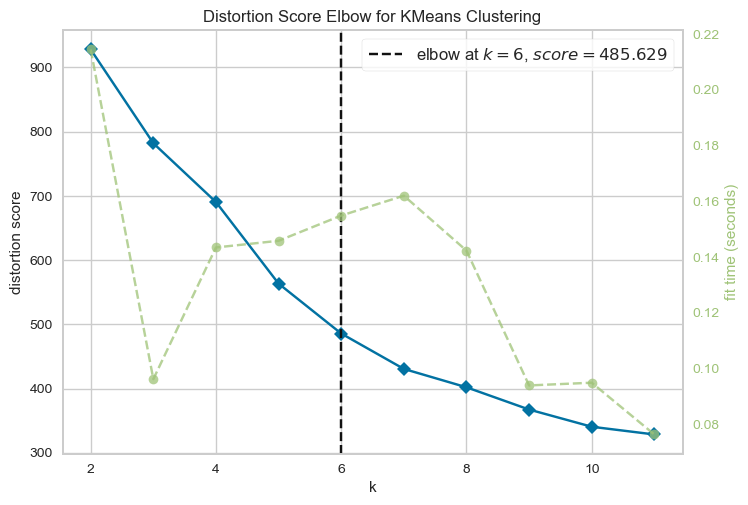

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2, 12))
visualizer.fit(X_scaled)
visualizer.show()

In [ ]:
from sklearn.cluster import KMeans

# clusters

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_scaled)

# luster labels
labels1 = kmeans.labels_

In [ ]:
# On peut stocker nos centroids dans une variable :

centroids = kmeans.cluster_centers_
centroids

array([[-0.18181579, -0.13865268, -0.17805182,  0.54858705, -0.31396915,
         0.34453443,  0.75301099],
       [-0.29157871, -0.19090036,  1.03909472, -1.23596049,  0.08715921,
        -0.37594989,  0.33085229],
       [ 0.03297484, -0.34214236, -0.70992432,  0.48783765,  0.2790386 ,
         0.01233341, -0.93460348],
       [ 7.84684242,  1.08295535, -0.85964303,  0.70347586, -0.26346814,
         1.03220477, -0.1332381 ],
       [ 0.50686581,  3.60721821,  0.53728032, -0.2579487 , -0.32464487,
        -0.42050457, -0.03964339]])

In [ ]:
from sklearn.cluster import KMeans

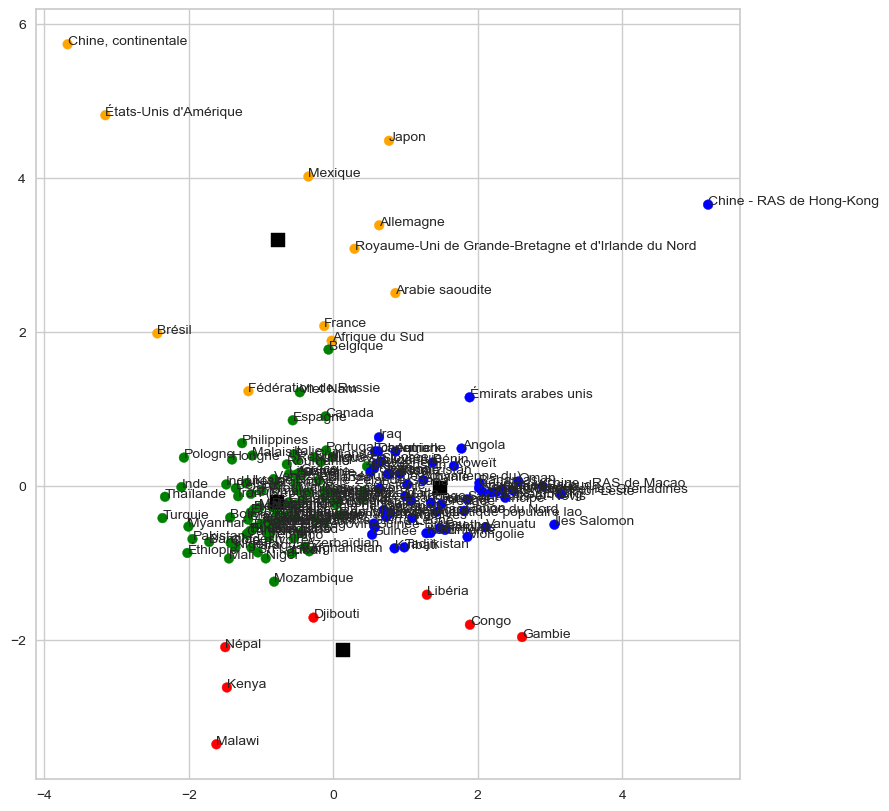

In [ ]:
fig = plt.figure(figsize=(20, 10))

X_trans = pca.fit_transform(df2)

cls4 = KMeans(n_clusters=4)
cls4.fit(X_trans)
ax = fig.add_subplot(122)
colors = ['red', 'green', 'blue', 'orange']
scatter = ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls4.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 1], marker='s', color='black',
            edgecolor='black', s=100)

for i, txt in enumerate(labels):
    ax.text(X_trans[i, 0], X_trans[i, 1], txt, fontsize=10)

    plt.savefig("cls4.png", bbox_inches='tight')

plt.show()

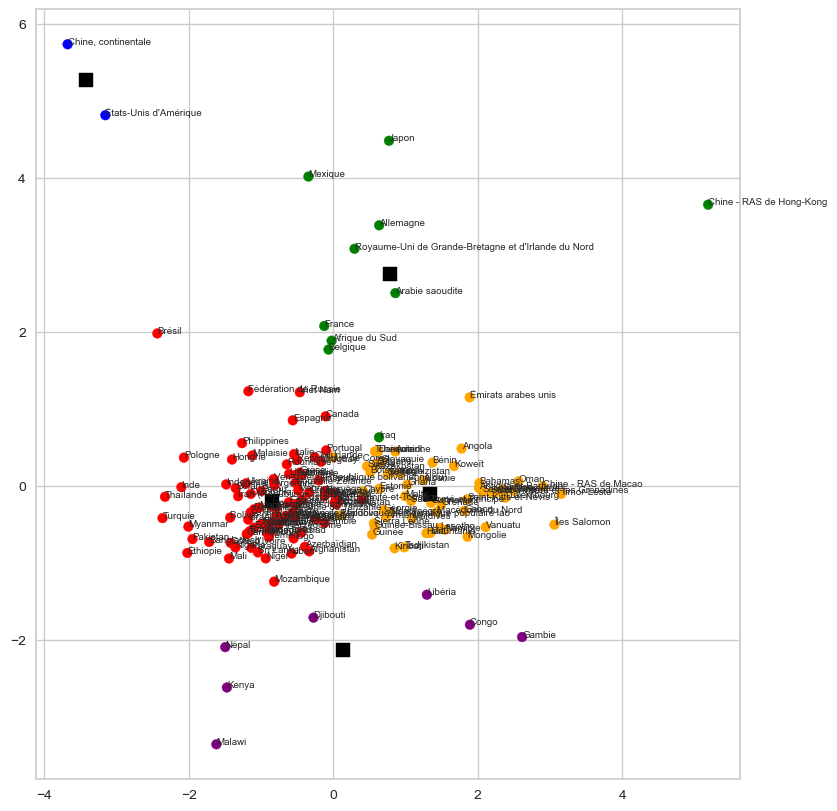

In [ ]:
fig = plt.figure(figsize=(20, 10))

X_trans = pca.fit_transform(df2)

cls5 = KMeans(n_clusters=5)
cls5.fit(X_trans)
ax = fig.add_subplot(122)

colors = ['red', 'green', 'blue', 'orange', 'purple']

scatter = ax.scatter(X_trans[:, 0], X_trans[:, 1], c=cls5.labels_, cmap=matplotlib.colors.ListedColormap(colors))

plt.scatter(cls5.cluster_centers_[:, 0], cls5.cluster_centers_[:, 1], marker='s', color='black',
            edgecolor='black', s=100)
for i, txt in enumerate(labels):
    ax.text(X_trans[i, 0], X_trans[i, 1], txt, fontsize=7)

plt.savefig("cls5.png", bbox_inches='tight')

plt.show()

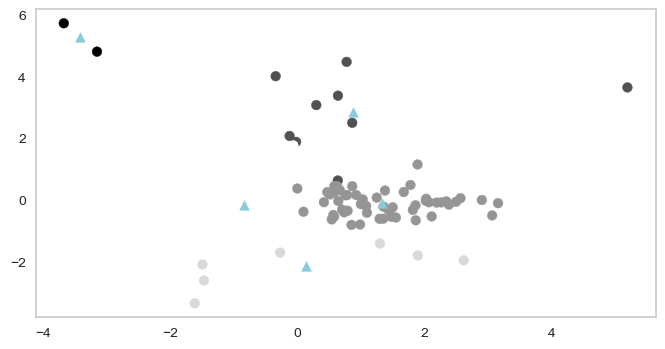

Inertie totale : 570.6040946514504


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

fig = plt.figure(figsize=(8, 4))

# Création et ajustement du modèle K-means avec 5 clusters
model = KMeans(n_clusters=5)
model.fit(X_trans)

# Prédiction des clusters pour chaque point
predictions = model.predict(X_trans)

# Affichage des points avec leurs clusters prédits
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=predictions)

# Affichage des centroïdes des clusters
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='^', c='c')

plt.grid()
plt.show()

# Affichage de l'inertie totale du modèle
print('Inertie totale :', model.inertia_)

# CLASSIFICATION ASCENDANTE HIÉRARCHIQUE (CAH)

## Dendrogram

* Un dendrogramme est une représentation graphique qui permet de visualiser les regroupements hiérarchiques entre les données

 * En utilisant le dendrogramme, on peut décider du nombre de clusters à utiliser en identifiant les coupures (cut-off) appropriées sur les branches. Une coupure sur une branche indique la formation de clusters distincts à ce niveau de similarité

In [ ]:
from sklearn import datasets

from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# Calcul du lien hiérarchique

Z = linkage(X_trans, method = 'ward', metric='euclidean')

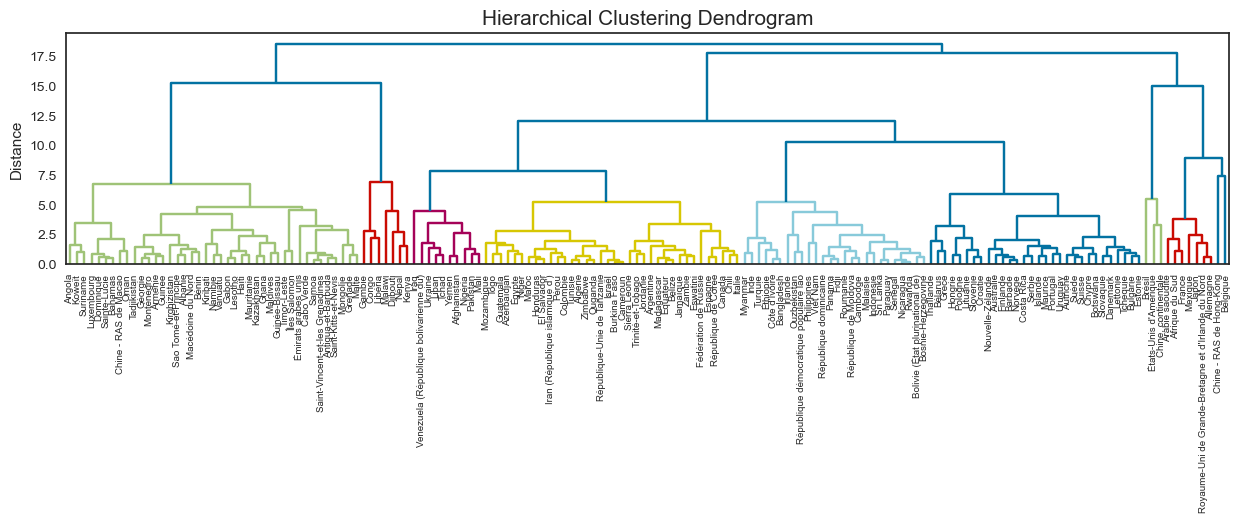

In [ ]:
fig =plt.figure(figsize=(15,3))
sns.set_style('white')
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
plt.ylabel('Distance')
dendrogram(Z, labels = df2.index, leaf_font_size=7, color_threshold=7, orientation='top')

plt.savefig("Dendrogram.png", bbox_inches='tight')

plt.show()

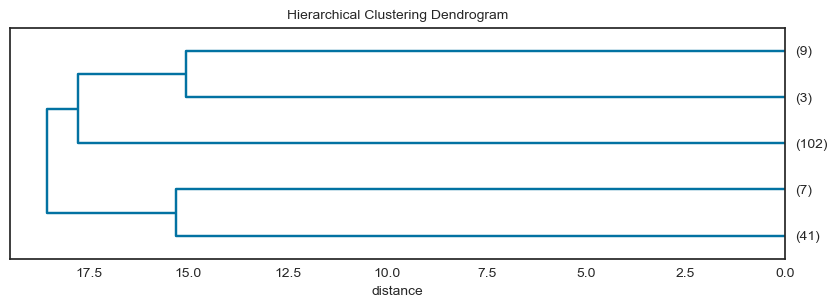

In [ ]:
fig = plt.figure(figsize=(10,3))
plt.title('Hierarchical Clustering Dendrogram', fontsize=10)
plt.xlabel('distance', fontsize=10)
dendrogram(Z, labels=df2.index, p=5, truncate_mode='lastp', leaf_font_size=10, orientation='left')
plt.show()

In [ ]:
cluster_CAH = fcluster(Z, 5, criterion='maxclust')
cluster_CAH

array([1, 3, 1, 1, 1, 1, 3, 1, 5, 5, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3,
       5, 3, 3, 3, 3, 3, 1, 1, 1, 2, 1, 3, 3, 5, 5, 3, 4, 3, 5, 2, 1, 1,
       3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 1, 3, 1, 1, 1, 1, 5, 4, 1, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 5,
       1, 1, 1, 1, 3, 3, 2, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3,
       3, 2, 3, 3, 3, 3, 3, 3], dtype=int32)

In [ ]:
df_cluster_CAH = pd.DataFrame(cluster_CAH, index=names, columns=['Cluster CAH'])
df_cluster_CAH

,Cluster CAH
Grenade,1
Trinité-et-Tobago,3
Antigua-et-Barbuda,1
Sainte-Lucie,1
Saint-Kitts-et-Nevis,1
...,...
Nigéria,3
Tchad,3
Éthiopie,3
Ouzbékistan,3


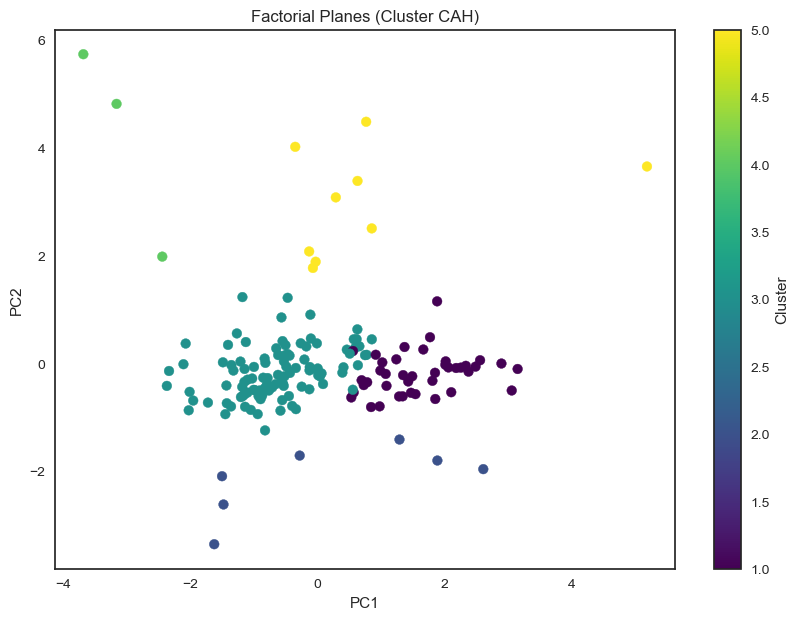

In [ ]:
import matplotlib.pyplot as plt

x = X_projected[:, 0]
y = X_projected[:, 1]

plt.figure(figsize=(10, 7))
plt.scatter(x, y, c=cluster_CAH, cmap='viridis', alpha=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Factorial Planes (Cluster CAH)')
plt.colorbar(label='Cluster')

plt.savefig("CAH.png", bbox_inches='tight')

plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

groupes_cah = fcluster(Z, 5, criterion='maxclust')

idg = np.argsort(groupes_cah)

# Affichage des pays selon leurs groupes
labels=df2.index
df1 = pd.DataFrame({'Groupe': groupes_cah[idg], 'Zone': labels[idg]})
df1

,Groupe,Zone
0,1,Grenade
1,1,Malte
2,1,Cabo Verde
3,1,Îles Salomon
4,1,Kirghizistan
...,...,...
157,5,Belgique
158,5,France
159,5,Japon
160,5,Allemagne


In [ ]:
df3 = pd.merge(df1, df2, left_on='Zone', right_index=True)
df3.set_index('Zone', inplace=True)
df3.head()

,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Zone,,,,,,,,
Grenade,1,-0.315443,-0.436659,0.801967,-1.429489,-0.107689,1.109516,1.206611
Malte,1,-0.312753,-0.425824,0.353108,-1.078617,-0.192814,1.589197,1.477973
Cabo Verde,1,-0.314546,-0.409571,1.430486,-1.484074,-0.533315,-0.492057,0.935249
Îles Salomon,1,-0.317684,-0.442076,2.977609,-1.702414,0.317938,-0.430559,0.290765
Kirghizistan,1,-0.304683,-0.339143,0.620567,-1.224686,-1.687615,0.731745,-0.365026


In [ ]:
#afficher les moyennes des variables de chaque groupe

groupe = (1, 2, 3, 4, 5)
results = []

for n in groupe:
    group = df3.loc[df3['Groupe'] == n].mean()
    group = group.abs().sort_values(ascending=False)
    group = group * np.sign(df3.loc[df3['Groupe'] == n].mean())

    results.append(group)

result_df = pd.DataFrame(results)
result_df.drop('Groupe', axis=1, inplace=True)
result_df.insert(0, 'Groupe', groupe)
result_df.set_index('Groupe', inplace=True)

result_df

,+Conso(%),Disponibilité intérieure,Importations - Quantité,PIB Valeur(%),Political_Valeur,TAS (%),TDI (%)
Groupe,,,,,,,
1,-0.154329,-0.291582,-0.193002,-0.214032,0.411830,-1.249470,1.004357
2,3.986158,-0.295844,-0.342239,-0.513392,-0.528166,-0.161526,0.465054
3,-0.169588,-0.100004,-0.226948,0.154348,-0.148979,0.446952,-0.483874
4,-0.158537,6.616667,0.569194,0.210187,-0.244421,0.936954,-0.869635
5,-0.422444,0.486242,3.527761,-0.445006,0.304584,0.439891,0.836670


In [ ]:
result_df.describe()

,+Conso(%),Disponibilité intérieure,Importations - Quantité,PIB Valeur(%),Political_Valeur,TAS (%),TDI (%)
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.616252,1.283096,0.666953,-0.161579,-0.041031,0.082560,0.190514
std,1.887246,2.998649,1.639423,0.333495,0.392063,0.840289,0.826732
min,-0.422444,-0.295844,-0.342239,-0.513392,-0.528166,-1.249470,-0.869635
25%,-0.169588,-0.291582,-0.226948,-0.445006,-0.244421,-0.161526,-0.483874
50%,-0.158537,-0.100004,-0.193002,-0.214032,-0.148979,0.439891,0.465054
75%,-0.154329,0.486242,0.569194,0.154348,0.304584,0.446952,0.836670
max,3.986158,6.616667,3.527761,0.210187,0.411830,0.936954,1.004357


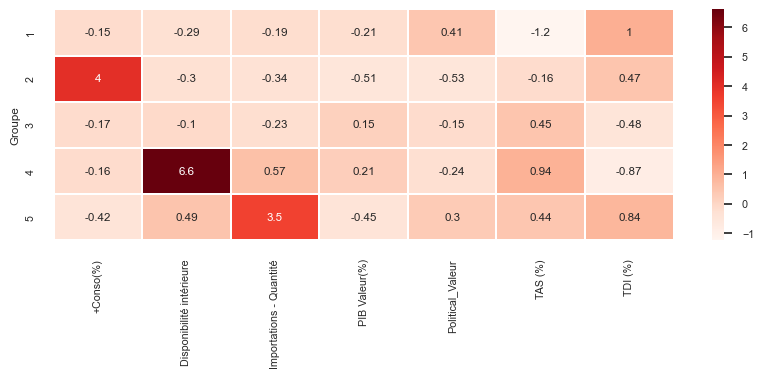

In [ ]:
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(10, 3))
sns.heatmap(result_df, ax=ax, cmap="Reds", linewidths=0.1, annot=True)
plt.savefig("groupe.png", bbox_inches='tight')
plt.show()

In [ ]:
# Cluster 1
cluster_1=df3.loc[df3['Groupe']==1]
cluster_1

# La consommation (%), la disponibilité, les importations et le PIB valeur sont tous inférieurs à la moyenne.
# La valeur politique est relativement élevée.
# TAS est très faible.
# TDI est élevé.

,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Zone,,,,,,,,
Grenade,1,-0.315443,-0.436659,0.801967,-1.429489,-0.107689,1.109516,1.206611
Malte,1,-0.312753,-0.425824,0.353108,-1.078617,-0.192814,1.589197,1.477973
Cabo Verde,1,-0.314546,-0.409571,1.430486,-1.484074,-0.533315,-0.492057,0.935249
Îles Salomon,1,-0.317684,-0.442076,2.977609,-1.702414,0.317938,-0.430559,0.290765
Kirghizistan,1,-0.304683,-0.339143,0.620567,-1.224686,-1.687615,0.731745,-0.365026
Géorgie,1,-0.291681,-0.198288,0.726738,-0.914861,-0.199454,0.891639,-0.353720
Lesotho,1,-0.311408,-0.393319,0.816278,-1.445646,-0.009454,-0.610659,-0.150198
Mongolie,1,-0.314994,-0.420406,1.258562,-1.702414,0.828690,0.859133,0.957863
Ghana,1,-0.224429,0.343464,0.493703,-1.081455,0.152284,0.202866,0.166391


In [ ]:
# Cluster 2
cluster_2=df3.loc[df3['Groupe']==2]
cluster_2

## La consommation (%) est considérablement élevée, bien au-dessus de la moyenne.
# La disponibilité intérieure, les importations quantitatives,
# PIB valeur et la valeur politique sont tous inférieurs à la moyenne.
# Le TAS et le TDI sont également en dessous de la moyenne.

,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Zone,,,,,,,,
Gambie,2,-0.315443,-0.387901,2.977609,-1.156564,3.893201,-1.151838,-0.025824
Népal,2,-0.293026,-0.474581,-0.890199,0.480987,3.572790,1.039233,-0.625081
Congo,2,-0.269712,0.088841,0.938308,-1.563550,3.640550,-2.918575,-0.534627
Kenya,2,-0.303337,-0.474581,-0.890199,0.480987,4.511211,-0.072994,-1.213032
Malawi,2,-0.275092,-0.474581,-0.890199,1.193868,6.986145,-0.352369,-0.218039
Djibouti,2,-0.317684,-0.458329,1.043705,0.480987,2.871698,1.011998,-0.772069
Libéria,2,-0.296612,-0.214540,0.966349,-1.047394,2.427514,-1.149202,-0.308493


In [ ]:
# Cluster 3
cluster_3=df3.loc[df3['Groupe']==3]
cluster_3

# La consommation (%) et la disponibilité intérieure sont légèrement inférieures à la moyenne.
# TDI est inférieur à la moyenne

,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Zone,,,,,,,,
Belize,3,-0.310511,-0.474581,-0.890199,0.595834,-0.344167,-0.945381,0.109857
Uruguay,3,-0.304234,-0.458329,-0.714407,0.480987,-1.312382,0.000803,1.251838
Sénégal,3,-0.284507,-0.474581,-0.890199,0.480987,0.278610,0.415472,0.008096
Guatemala,3,-0.158971,0.224279,-0.191479,-0.265081,0.040940,-0.045760,-0.670308
Bosnie-Herzégovine,3,-0.294371,-0.420406,-0.538615,0.719196,0.147687,1.055047,-0.331106
...,...,...,...,...,...,...,...,...
Costa Rica,3,-0.258952,-0.382484,-0.644786,0.464612,-0.170682,0.255578,0.754341
Tunisie,3,-0.231603,-0.474581,-0.890199,0.682515,-0.173746,-0.491178,-1.088658
Sri Lanka,3,-0.232948,-0.474581,-0.890199,0.480987,0.966933,0.642134,-0.014517


In [ ]:
# Cluster 4
cluster_4=df3.loc[df3['Groupe']==4]
cluster_4

# la disponibilité intérieure est très élevée.

,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Zone,,,,,,,,
États-Unis d'Amérique,4,7.870380,0.191773,-0.877242,0.917013,-0.294284,-0.244309,0.392525
Brésil,4,4.156318,-0.458329,-0.889619,1.403911,0.051325,-1.433848,-0.466787
"Chine, continentale",4,7.823304,1.974137,-0.842044,0.489939,-0.232653,2.308719,-0.659002


In [ ]:
# Cluster 5
cluster_5=df3.loc[df3['Groupe']==5]
cluster_5

# La consommation (%) est considérablement inférieure à la moyenne.
# La disponibilité intérieure, les importations, le PIB valeur et le TAS sont tous proches de la moyenne.
# La valeur politique et le TDI sont légèrement supérieurs à la moyenne

,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
Zone,,,,,,,,
Arabie saoudite,5,0.324341,3.436867,0.082748,-0.765080,-0.503011,-1.024450,-0.659002
Chine - RAS de Hong-Kong,5,-0.193494,4.439108,5.374297,-1.515297,-0.810654,0.096563,1.003090
Afrique du Sud,5,0.630558,2.310023,-0.420840,0.016141,-0.135099,-0.947139,-0.251959
Mexique,5,1.572524,4.791247,-0.444627,-0.020977,-0.244570,-0.360276,-0.839910
Belgique,5,-0.250882,1.356540,3.410224,4.948445,-0.559534,-0.485907,0.550820
France,5,0.386212,2.266683,-0.268062,0.726620,-0.504032,-0.526319,0.381219
Japon,5,0.763716,5.316746,-0.034059,0.300202,-0.402903,-0.278572,1.319678
Allemagne,5,0.460637,4.086970,0.046198,0.198455,-0.475430,-0.329527,0.731728
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord,5,0.682566,3.745666,-0.215846,0.070508,-0.166766,-0.149427,0.505593


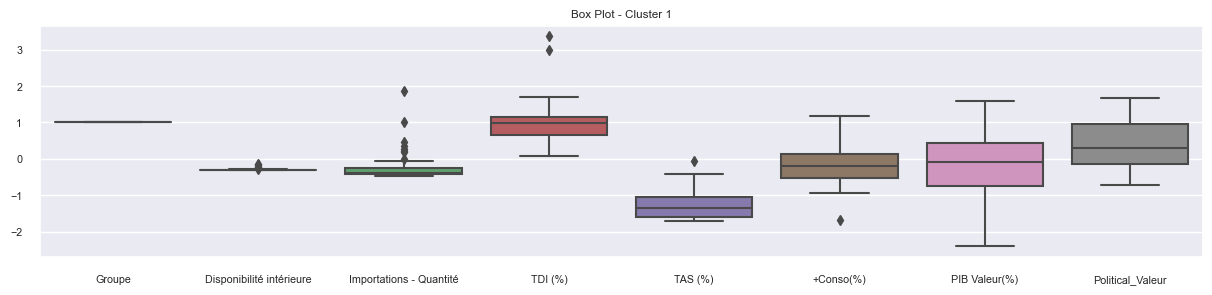

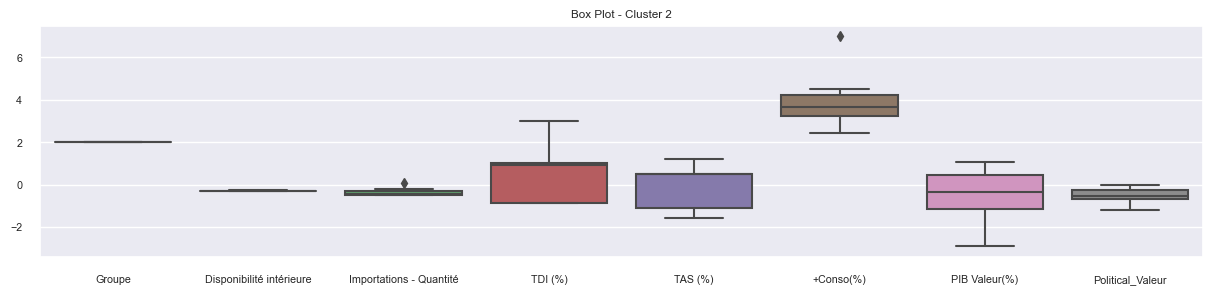

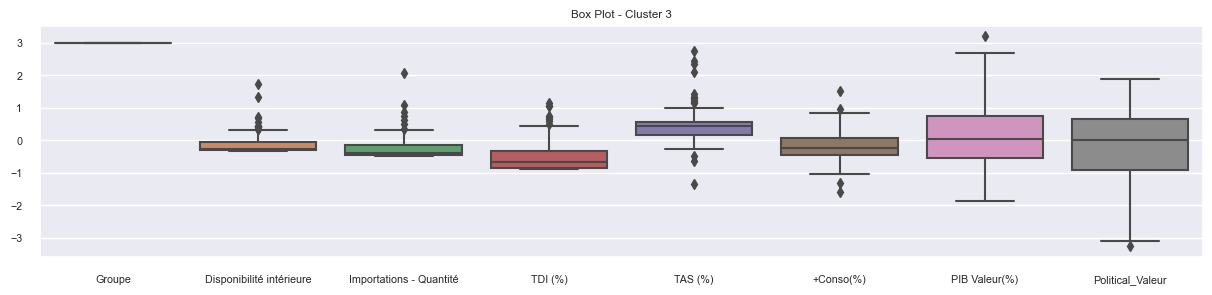

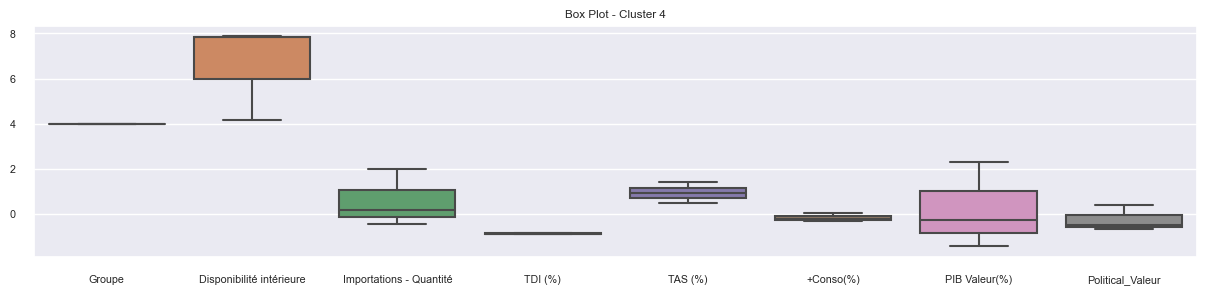

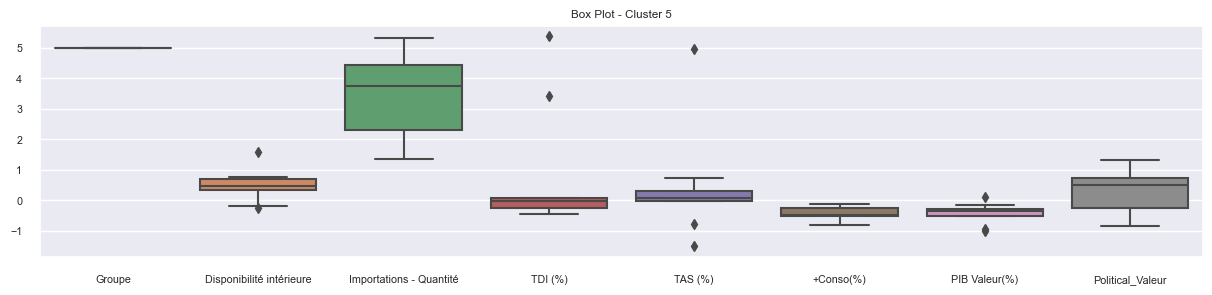

In [ ]:
for i in range(1, 6):
    cluster = df3.loc[df3['Groupe'] == i]

    plt.figure(figsize=(15, 3))
    sns.boxplot(data=cluster)  # Use 'cluster' instead of 'df3'
    plt.title(f'Box Plot - Cluster {i}')

    plt.savefig(f"boxplot_cluster_{i}.png", bbox_inches='tight')  # Save each plot with a unique name

    plt.show()

<Figure size 700x700 with 0 Axes>

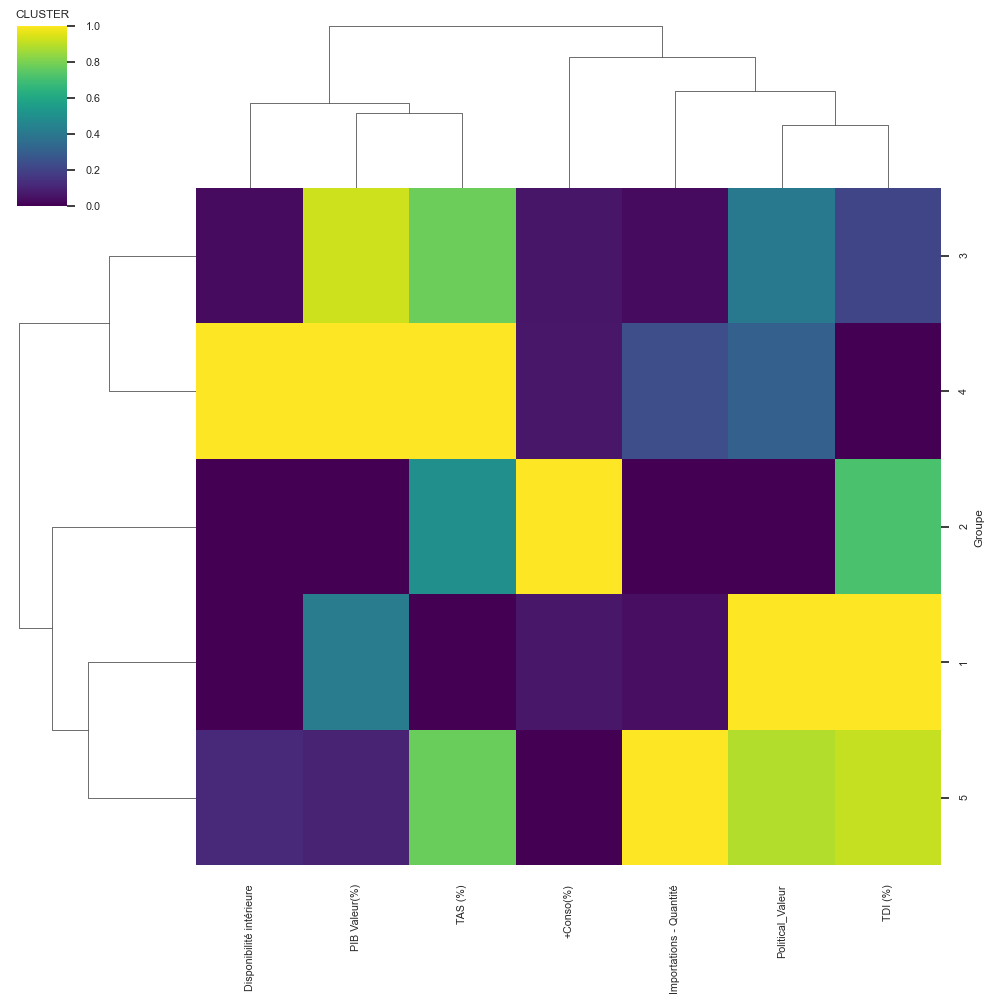

In [ ]:
#heatmap avec les croisements entre les clusters de pays et les différentes variables

plt.figure(figsize=(7, 7))
sns.clustermap(result_df, cmap = 'viridis',method = 'ward',metric = 'euclidean',standard_scale =1)
plt.title('CLUSTER')
plt.savefig('Heatmap Cluster.jpg');

# CARTE

In [ ]:
df3 = df3.reset_index()
df3.head(2)

,Zone,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur
0,Grenade,1,-0.315443,-0.436659,0.801967,-1.429489,-0.107689,1.109516,1.206611
1,Malte,1,-0.312753,-0.425824,0.353108,-1.078617,-0.192814,1.589197,1.477973


In [ ]:
code = pd.read_csv('codes.csv',sep =';')
code

,ISO3 CODE,Zone
0,AFG,Afghanistan
1,ZAF,Afrique du Sud
2,ALB,Albanie
3,DZA,Algérie
4,DEU,Allemagne
...,...,...
239,YEM,Yémen
240,YE2,"Yémen, Ancien Yémen démocratique"
241,YU1,"Yougoslavie, Ancienne Rép. socialiste de"
242,ZMB,Zambie


In [ ]:
df3 = df3.merge(code, on ='Zone', how = 'inner')
df3

,Zone,Groupe,Disponibilité intérieure,Importations - Quantité,TDI (%),TAS (%),+Conso(%),PIB Valeur(%),Political_Valeur,ISO3 CODE
0,Grenade,1,-0.315443,-0.436659,0.801967,-1.429489,-0.107689,1.109516,1.206611,GRD
1,Malte,1,-0.312753,-0.425824,0.353108,-1.078617,-0.192814,1.589197,1.477973,MLT
2,Kirghizistan,1,-0.304683,-0.339143,0.620567,-1.224686,-1.687615,0.731745,-0.365026,KGZ
3,Géorgie,1,-0.291681,-0.198288,0.726738,-0.914861,-0.199454,0.891639,-0.353720,GEO
4,Lesotho,1,-0.311408,-0.393319,0.816278,-1.445646,-0.009454,-0.610659,-0.150198,LSO
...,...,...,...,...,...,...,...,...,...,...
150,Belgique,5,-0.250882,1.356540,3.410224,4.948445,-0.559534,-0.485907,0.550820,BEL
151,France,5,0.386212,2.266683,-0.268062,0.726620,-0.504032,-0.526319,0.381219,FRA
152,Japon,5,0.763716,5.316746,-0.034059,0.300202,-0.402903,-0.278572,1.319678,JPN
153,Allemagne,5,0.460637,4.086970,0.046198,0.198455,-0.475430,-0.329527,0.731728,DEU


In [ ]:
df3.to_csv('df3.csv', index=False)

In [ ]:
import folium
import json

f = open ('world-countries.json', "r")
state_geo = json.loads(f.read())

m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=df3,
    columns=["ISO3 CODE", "Groupe"],
    key_on="feature.id",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    nan_fill_color='white',
    line_opacity=0.2,
    legend_name="Clusters obtenus",
    reset=True,
    bins=8,
).add_to(m)

folium.LayerControl().add_to(m)

plt.savefig("carte.png", bbox_inches='tight')

m

<Figure size 800x550 with 0 Axes>

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
eps_test = np.arange(2.0, 10.0, 0.2)
samples_test = np.arange(2, 10, 1)
df_dbscan = pd.DataFrame()

for i_eps in eps_test:
    for i_samples in samples_test:
        db = DBSCAN(eps=i_eps, min_samples=i_samples).fit(df2)
        labels = db.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        if n_clusters_ > 1:
            silhouette_score = metrics.silhouette_score(df2, labels)
        else:
            silhouette_score = np.nan

        df_dbscan = df_dbscan.append({'samples': i_samples,
                                      'epsilon': i_eps,
                                      'silhouette': silhouette_score,
                                      'cluster': n_clusters_}, ignore_index=True)

df_dbscan.sort_values(by='silhouette')

/var/folders/62/rh3k63454234qh974djnz0xm0000gn/T/ipykernel_43012/1750277548.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dbscan = df_dbscan.append({'samples': i_samples,
/var/folders/62/rh3k63454234qh974djnz0xm0000gn/T/ipykernel_43012/1750277548.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dbscan = df_dbscan.append({'samples': i_samples,
/var/folders/62/rh3k63454234qh974djnz0xm0000gn/T/ipykernel_43012/1750277548.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_dbscan = df_dbscan.append({'samples': i_samples,
/var/folders/62/rh3k63454234qh974djnz0xm0000gn/T/ipykernel_43012/1750277548.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

,samples,epsilon,silhouette,cluster
0,2.0,2.0,0.377055,2.0
4,6.0,2.0,0.395941,2.0
5,7.0,2.0,0.395941,2.0
56,2.0,3.4,0.555863,2.0
64,2.0,3.6,0.555863,2.0
...,...,...,...,...
315,5.0,9.8,NaN,1.0
316,6.0,9.8,NaN,1.0
317,7.0,9.8,NaN,1.0
318,8.0,9.8,NaN,1.0


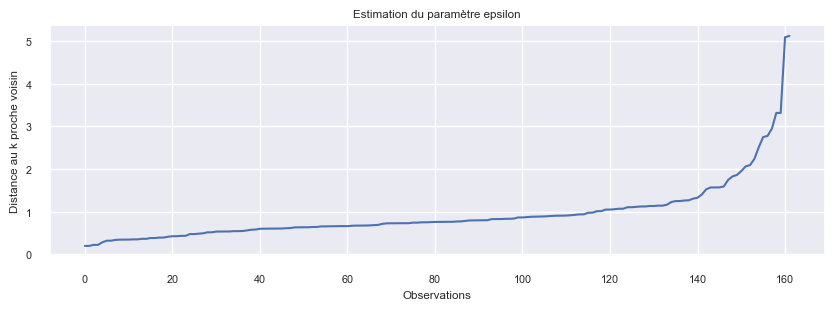

In [ ]:
kplusproche = NearestNeighbors(n_neighbors=2)
nbrs = kplusproche.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = plt.figure(figsize=(10,3))
plt.title('Estimation du paramètre epsilon')
plt.plot(distances)
plt.xlabel("Observations")
plt.ylabel("Distance au k proche voisin");

In [ ]:
db = DBSCAN(eps=2.5, min_samples=2).fit(X_scaled)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters_ > 1:
    silhouette_score = metrics.silhouette_score(X_scaled, labels)
    print("Silhouette Score:", silhouette_score)
    print("Number of clusters:", n_clusters_)
else:
    print("Insufficient clusters to compute silhouette score.")


Insufficient clusters to compute silhouette score.
